<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/%EA%B8%B0%EC%B4%88%ED%86%B5%EA%B3%84/logreg_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 미분과 최적화를 사용한 프로그래밍 프로젝트: 로지스틱 회귀 스팸 메일 필터

## 모듈 로딩

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 작성된 모델을 평가 하기 위한 추가 라이브러리 로딩
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

## 데이터 준비

In [ ]:
# 데이터 파일 가져오기
!gdown 16FxXGZDQK_8C5nW9o5H5lUAVRBG2YwKa

Downloading...
From: https://drive.google.com/uc?id=16FxXGZDQK_8C5nW9o5H5lUAVRBG2YwKa
To: /content/spam.csv
100% 154k/154k [00:00<00:00, 3.27MB/s]


In [ ]:
# pandas 라이브러리를 이용해 DataFrame 형식으로 데이터 읽어오기
data = pd.read_csv('spam.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3423 entries, 0 to 3422
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  3423 non-null   object
 1   spam     3423 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 30.2+ KB


In [ ]:
# 3000개 학습 세트로 423개 테스트 세트로 나누기
data_train = data[:3000]
data_test = data[3000:]

- 데이터 샘플은 다음처럼 제목과 스팸인지 아닌지를 구별하는 타겟으로 구성되어 있음





In [ ]:
data_train.loc[0:0]

,subject,spam
0,[ILUG] Garden Ornaments | mvcmv,True


### Bow

- 로지스틱 회귀 모델에 제목을 입력하고 모델의 출력으로 스팸(True)인지 아닌지(False)를 출력하게 하려면 메일의 제목은 문자가 아니라 숫자로 변경되어야 함

- 문자를 숫자로 변경하는 다양한 방식이 있지만 여기서는 가장 간단한 방식은 BoW(Bag of Words) 방식을 사용

- BoW는 학습 샘플에 등장하는 모든 단어를 사용해 단어장을 만들고 샘플에 단어가 해당 단어장에 몇번째 등장하는 단어인지를 조회해 문장을 숫자로 바꾸는 방식

- 다음은 간단한 예를 보여주고 있음
```
V = ['love', 'I', 'me', 'you', 'hate']
subject = "I love you"
subject_int = [1, 0, 3]
```

- 위 처럼 바꾼후 단어장 길이의 0으로 채워진 벡터를 만들고 `subject_int`에 나타난 인덱스 자리만 1로 바꿔 마무리
```
subject_enc = [1, 1, 0, 1, 0]
```

- 이런 방식으로 모든 문장을 단어장 길이를 크기로 가지는 0, 1로 이뤄진 벡터로 변환 할 수 있음

- 이 방식의 장점은 구현이 간단하며 숫자로 변환된 문장이 무조건 동일한 길이의 벡터가 된다는 점이며

- 단점은 단어의 순서가 사라져 문장 구조에 대한 정보를 잃게 됨

- 사이킷런 라이브러리는 위와 같은 작업을 구현해 놓은 `CounterVectorizer()`를 제공함

In [ ]:
cv = CountVectorizer()
cv.fit(data_train['subject'])

CountVectorizer()

In [ ]:
# 내부적으로 구축된 단어장 길이를 조회
len(cv.vocabulary_)

4153

In [ ]:
# 구축된 cv로 학습 샘플과 테스트 샘플을 숫자로 변환
X_train = cv.transform(data_train['subject']).toarray()
y_train = data_train['spam'].astype(float).to_numpy()

X_test = cv.transform(data_test['subject']).toarray()
y_test = data_test['spam'].astype(float).to_numpy()

In [ ]:
X_train.shape

(3000, 4153)

## 모델 만들기

### 라이브러리 제공 모델 학습

- 먼저 수업에서 배운 가장 간단한 최적화 방식인 러닝레이트를 고정한 최속강하법으로 모델을 학습시킴

- 이를 위해 사이킷런에서 제공하는 `SGDClassifier`를 사용


In [ ]:
logreg = SGDClassifier(loss='log_loss', penalty='l2',
                       alpha=0.0001, l1_ratio=0.0,
                       fit_intercept=False, max_iter=150,
                       learning_rate='constant', eta0=0.01)
logreg.fit(X_train, y_train)

SGDClassifier(eta0=0.01, fit_intercept=False, l1_ratio=0.0,
              learning_rate='constant', loss='log_loss', max_iter=150)

### 직접 만들어 학습


#### 손실함수 포워드 패스

$$
L(\mathbf{w}) = - \sum_{i=1}^N y_i \log \left(\sigma(\mathbf{w} \cdot  \mathbf{x}_i) \right) + (1-y_i) \log \left(1 - \sigma(\mathbf{w} \cdot \mathbf{x}_i) \right) \tag{1}
$$

- 위 식에서

- $N$은 샘플의 개수

- $y_i$는 $i$번째 샘플의 타겟인 0 아니면 1인 숫자

- $\mathbf{x}_i$는 $(D,)$인 벡터이고 현재 문제에서 $D=4153$

- $\mathbf{w}$는 입력 $\mathbf{x}_i$의 각 숫자에 곱해질 $(D,)$인 가중치 벡터

- 따라서 $\mathbf{w} \cdot \mathbf{x}_i$는 두 벡터의 내적을 나타냄

- $\sigma(x)=\frac{1}{1+\exp(-x)}$ 인 로지스틱 시그모이드 함수


- 위 손실 함수의 함수값을 계산하는 코드를 `Loss.forward(self, w, X, y)`에 코딩한다.

- `self.cost` 변수에 함수값 저장

- 넘파이를 활용해도 좋고 `for`문으로 직관적으로 구현해도 좋음


#### 손실함수 포워드 패스 규제

- `self.cost`에 위 식(1)이 계산되었다면 규제항을 추가

- 규제 항은 아래 식으로 추가됨

$$
L_{\text{reg}}(\mathbf{w}) = L(\mathbf{w}) + \frac{\lambda}{2} \lVert \mathbf{w} \rVert^2 \tag{2}
$$

- 위 식에서

- $\lambda$는 규제 효과를 조정하는 주어지는 상수

- $\lVert \mathbf{w} \rVert^2 = w_1^2 + w_2^2 + \cdots + w_D^2$

- `Loss.forward()`함수는 최종적으로 위 식 $L_{\text{reg}}$ 값을 반환


#### 손실함수 백워드 패스

- 약간의 미분 과정을 거치면 규제 없는 손실함수 $L(\mathbf{w})$에 대한 $\mathbf{w}$의 미분은 다음처럼 주어짐

$$
\frac{\partial }{\partial \mathbf{w}} L(\mathbf{w}) = \sum_{i=1}^N \left\{-y_i + \sigma(\mathbf{w} \cdot \mathbf{x}_i) \right\} \mathbf{x}^\intercal_i \tag{3}
$$

- 위 식은 $\mathbf{w}$에 대한 그래디언트는 $\mathbf{x}_i$를 더해서 만들어지는데 이 때 각 $\mathbf{x}_i$에 대한 덧셈 가중치를 $\mathbf{x}_i$에 대한 모델의 출력이 만들어내는 에러 $\left\{-y_i + \sigma(\mathbf{w} \cdot \mathbf{x}_i) \right\}$만큼 설정한다는 의미

- 위 손실 함수의 그래디언트를 계산하는 코드를 `Loss.backward(self, w, X, y)`에 코딩한다.

- `self.dw`에 그래디언트 값 저장

- 넘파이를 활용해도 좋고 `for`문으로 직관적으로 구현해도 좋음


#### 손실함수 백워드 패스 규제

- `self.dw`에 위 식(2)가 계산되었다면 규제항의 미분값을 추가

- 규제 항의 미분은 다음과 같음

$$
\frac{\partial}{\partial \mathbf{w}} \left(\frac{\lambda}{2}  \lVert  \mathbf{w} \rVert^2 \right) = \lambda \mathbf{w} \tag{4}
$$

- 따라서 최종 그래디언트는 다음과 같음

$$
\frac{\partial}{\partial \mathbf{w}} L_{\text{reg}}(\mathbf{w}) = \frac{\partial}{\partial \mathbf{w}} L(\mathbf{w}) + \lambda \mathbf{w} \tag{5}
$$

- `Loss.backward()`함수는 최종적으로 위 식 값을 반환

In [ ]:
def logistic(x):
    return 1.0 / (1 + np.exp(-x))


class Loss :
    def __init__(self, X, y, lamda):
        self.X = X # ( 데이터 개수 N, 데이터 차원 D )
        self.N = X.shape[0]
        self.y = y # ( 데이터 개수 N, )
        self.lamda = lamda

        # 우리가 구해야 하는 파라미터 w, 최초는 무작위로 설정
        self.w = np.random.randn(X.shape[1])

        # 코스트 초기화
        self.cost = 0.0

        # 미분 계수 초기화
        self.dw = 0.0

    def forward(self, w, X, y):
        """
        아래 식에 맞춰 로스 함수를 코딩
        - sum_i( y_i*log(sigma(w*x_i)) + (1-y_i)*log(1-sigma(w*x_i)) )
        """

        # self.cost에 손실함수 값을 계산해서 대입
        # (N,)                   (N,D), (D,)
        sigma = logistic( np.dot(  X,    w  ) )
        self.cost = - np.sum( y * np.log(sigma) + (1-y)*np.log(1-sigma) )

        # regularization
        # reg 변수에 규제 항 값을 대입하고
        # self.cost에 reg를 추가해서 반환
        reg = (self.lamda/2)*np.sum(w**2)
        self.cost += reg

        return self.cost

    def backward(self, w, X, y):
        # self.dw에 규제 없는 손실함수의 미분 값을 대입
        # sum_i { -y_i + sigma(w^T * x_i) } x_i^T
        # self.dw = np.dot( X.T, -y + logistic(np.dot(X, w)) )

        self.dw = np.zeros(X.shape[1])
        for i in range(self.N):
            self.dw += (logistic(np.dot(X[i], w)) - y[i]) * X[i]

        # regularization
        # reg 변수에 규제 항 미분 값을 대입하고
        # self.dw에 reg를 추가해서 반환
        reg = self.lamda * w
        self.dw += reg

        return self.dw

    def train(self, lr=0.01, epoch=100, verbose=False, verbose_step=100) :
        # lr: 러닝 레이트
        # epoch: 에폭수
        # verbose: 학습 과정 중간 출력 여부 지정
        # verbose_step: 학습 과정 출력 간격

        ep_mean_costs = []

        # 전체 에폭만큼 루프를 돌면서
        for i in range(epoch):
            costs = []

            # [1] self.w에 대해서 포워드 함수값을 계산해서 self.cost를 계산
            self.forward(self.w, self.X, self.y)

            # [2] self.w에 대한 미분계수 self.dw를 계산
            self.backward(self.w, self.X, self.y)

            # [3] self.dw를 이용하여 self.w를 업데이트(스탭 이동)
            #     학습률은 lr을 사용
            self.w = self.w - lr * self.dw

            # 줄어드는 코스트를 저장해서 반환하기 위해 계산된 코스트를 저장
            costs.append(self.cost)

            mean_costs = np.mean(costs)

            # 중간 과정을 출력해야 한다면 여기서 간단히 출력
            if verbose and ((i+1) % verbose_step == 0):
                print( f"Epoch {i+1:3d}: Cost={mean_costs:.5f}, lr={lr:.5f}" )

            # 한 에폭에 발생한 로스를 평균하여 에폭당 로스로 저장
            ep_mean_costs.append(mean_costs)

        return ep_mean_costs

###############################################################################

#### Sanity check

- 학습에 있어서 정확한 그래디언트가 제일 중요히기 때문에 작성된 `backward()`함수가 정확히 그래디언트를 계산하는지 반드시 체크해야 함

- 체크 방법은 수치 미분 함수와 `backward()`가 게산하는 그래디언트가 유사한지 확인하는 것

In [ ]:
def numer_deriv(x, fun, args=(), h=None, method="central", dtype='float32'):
    """
    Find the first derivative of a function at a point x.

    x     : The point at which derivative is found.
    fun   : Input function.
    args  : Tuple extra arguments passed to fun.
    h     : Step size
    method: 'central' or 'forward'
    dtype : Data type of gradient, must be set to 'longdouble'
            if numerically unstable.
    """

    # [1] 필요변수 초기화
    scalar = False
    m = 1

    # [2] x가 스칼라인지 벡터인지 확인 스칼라면 무조건 벡터로 고치고 시작
    if not hasattr(type(x), '__iter__'):
        x = np.array([x])
        scalar = True

    # [3] x 타입을 디폴트로 float32로 변경
    x = x.astype(dtype)

    # [4] 미분 계수 초기화
    g = np.zeros(x.shape[0]).astype(dtype)

    # [5] 미분계수를 변수 개수만큼 루프를 돌면서 구하기
    for i in range(x.shape[0]) :
        # [5-1]변경된 위치를 설정할 변수 두개를 준비
        # dx1[i], dx2[i]로 각 변수의 요소를 접근할 수 있음
        dx1 = x.copy()
        dx2 = x.copy()

        # [5-2] h 결정 대충 변수의 1%정도
        # https://en.wikipedia.org/wiki/Numerical_differentiation
        if h == None:
            h = np.sqrt(np.finfo(np.float32).eps) if x[i] == 0.0 else np.sqrt(np.finfo(np.float32).eps) * x[i]

        ##########################################
        # WRITE YOUR CODE HERE
        # [5-3*] dx1[i] 변경
        dx1[i] += h

        # [5-4*] central이면 dx[2]도 함께 변경, 이 때 m = 2로 설정해서
        # [5-5]에서 g[i]를 계산할 때 2h로 나누게 해야함.
        if method == "central":
            dx2[i] -= h
            m = 2

        # [5-5*] 미분계수 계산
        # fun이 스칼라 함수여도 요소 한개짜리 ndarray로 전달되면 문제없이
        # 호출되므로 여기거 fun은 fun(dx1, *args) 식으로 호출되면 됨
        g[i] = (fun(dx1, *args) - fun(dx2, *args)) / (m*h)
        ##########################################

    # [6] 결과값 리턴
    if scalar:
        return g[0]
    else:
        return g

- 위 수치 미분 함수를 사용해서 $D=10$인 가상의 데이터 두개에 대해서 유효성 검사를 수행

- 아래 셀을 실행했을 때 `numerical ∇J(w)`의 결과와 `∇J(w)` 결과가 거의 유사하게 나와야 함(두 결과는 숫자 열개로 구성된 벡터)

In [ ]:
# 가상의 개, 고양이 데이터 X와 정답 레이블 y를 정의
X_train_sanity = np.array(
    [[0,1,0,0,1,1,1,0,0,0],   # 개     1
     [1,0,0,1,1,1,1,0,1,0]])  # 고양이 0
y_train_sanity = np.array([1, 0])

# 데이터 차원
D = 10

loss_sanity = Loss(X_train_sanity, y_train_sanity, lamda=0.001)

w = np.random.rand(D)
print("w")
print(w)

# forward(self, w, X, y)
print("\nL(w)")
print(loss_sanity.forward(w, X_train_sanity, y_train_sanity))

print("\nnumerical ∇L(w)")
print(numer_deriv(w, loss_sanity.forward,
                  args=(X_train_sanity, y_train_sanity)))

print("\n∇L(w)")
print(loss_sanity.backward(w, X_train_sanity, y_train_sanity))


w
[0.80270183 0.65224675 0.92962012 0.26111291 0.98268921 0.8213555
 0.36506248 0.68074464 0.32267618 0.75975879]

L(w)
3.644043248826353

numerical ∇L(w)
[ 9.7308481e-01 -5.5532090e-02  9.2951319e-04  9.7243911e-01
  9.1708082e-01  9.1691911e-01  9.1636425e-01  6.8089744e-04
  9.7250062e-01  7.5961143e-04]

∇L(w)
[ 9.73031676e-01 -5.55288515e-02  9.29620123e-04  9.72490087e-01
  9.17030565e-01  9.16869232e-01  9.16412939e-01  6.80744640e-04
  9.72551650e-01  7.59758786e-04]


- Sanity check가 통과 되었으면 아래 셀을 수행하여 학습 진행

#### 학습

In [ ]:
# 분류기를 만들고
loss = Loss(X_train, y_train, lamda=0.0001)

In [ ]:
# 학습시킨다.
costs = loss.train(lr=0.01, epoch=150, verbose=True, verbose_step=5)

Epoch   5: Cost=1723.07667, lr=0.01000
Epoch  10: Cost=1349.00455, lr=0.01000
Epoch  15: Cost=1109.36634, lr=0.01000
Epoch  20: Cost=950.15946, lr=0.01000
Epoch  25: Cost=838.55593, lr=0.01000
Epoch  30: Cost=753.30507, lr=0.01000
Epoch  35: Cost=684.90480, lr=0.01000
Epoch  40: Cost=628.48307, lr=0.01000
Epoch  45: Cost=581.02396, lr=0.01000
Epoch  50: Cost=540.48268, lr=0.01000
Epoch  55: Cost=505.40598, lr=0.01000
Epoch  60: Cost=474.72834, lr=0.01000
Epoch  65: Cost=447.64869, lr=0.01000
Epoch  70: Cost=423.55180, lr=0.01000
Epoch  75: Cost=401.95653, lr=0.01000
Epoch  80: Cost=382.48084, lr=0.01000
Epoch  85: Cost=364.81751, lr=0.01000
Epoch  90: Cost=348.71682, lr=0.01000
Epoch  95: Cost=333.97391, lr=0.01000
Epoch 100: Cost=320.41933, lr=0.01000
Epoch 105: Cost=307.91178, lr=0.01000
Epoch 110: Cost=296.33257, lr=0.01000
Epoch 115: Cost=285.58120, lr=0.01000
Epoch 120: Cost=275.57191, lr=0.01000
Epoch 125: Cost=266.23098, lr=0.01000
Epoch 130: Cost=257.49457, lr=0.01000
Epoch 135

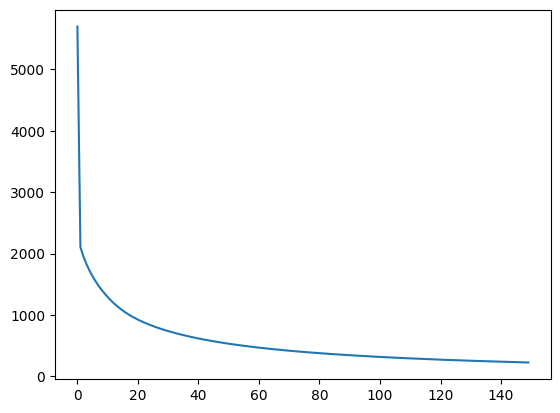

In [ ]:
# 학습하는 동안 기록한 로스를 시각화
plt.plot(costs)
plt.show()

- 미리 만들어 놓은 사이킷런 `SGDClassifier`와 성능 비교를 통해 코드 유효성 확인

- 결과는 아래와 같이 나오는데 `precision`, `recall`이 두 모델에서 비슷하게 나와야 함
```
              precision    recall  f1-score   support
         0.0       0.98      0.99      0.99      2561
         1.0       0.97      0.90      0.93       439
    
      accuracy                         0.98      3000
     macro avg     0.97      0.95      0.96      3000
weighted avg     0.98      0.98      0.98      3000
```

In [ ]:
print("scikit-learn SGDClassifier")
print("-----------------------------------------------------")
y_train_pred = logreg.predict(X_train)
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

print()

print("Ours")
print("-----------------------------------------------------")
y_train_pred = np.array([logistic(np.dot(X, loss.w)) for X in X_train])
y_train_pred  = y_train_pred > 0.50
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))


scikit-learn SGDClassifier
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2561
         1.0       0.97      0.90      0.94       439

    accuracy                           0.98      3000
   macro avg       0.98      0.95      0.96      3000
weighted avg       0.98      0.98      0.98      3000

[[2548   13]
 [  42  397]]

Ours
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2561
         1.0       0.97      0.94      0.96       439

    accuracy                           0.99      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       0.99      0.99      0.99      3000

[[2547   14]
 [  25  414]]


In [ ]:
print("scikit-learn SGDClassifier")
print("-----------------------------------------------------")
y_test_pred = logreg.predict(X_test)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

print()

print("Ours")
print("-----------------------------------------------------")
y_test_pred = np.array([logistic(np.dot(X, loss.w)) for X in X_test])
y_test_pred  = y_test_pred > 0.50
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

scikit-learn SGDClassifier
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       359
         1.0       0.76      0.73      0.75        64

    accuracy                           0.92       423
   macro avg       0.86      0.85      0.85       423
weighted avg       0.92      0.92      0.92       423

[[344  15]
 [ 17  47]]

Ours
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       359
         1.0       0.72      0.72      0.72        64

    accuracy                           0.91       423
   macro avg       0.83      0.83      0.83       423
weighted avg       0.91      0.91      0.91       423

[[341  18]
 [ 18  46]]
